In [ ]:
import cv2
import json
from matplotlib import pyplot as plt
import numpy as np
import os
import glob
from typing import Dict

# import a lot of things from keras:
# sequential model
from keras.models import Sequential

# layers
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, RandomFlip, RandomRotation, RandomContrast, RandomBrightness

# loss function
from keras.metrics import categorical_crossentropy

# callback functions
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# convert data to categorial vector representation
from keras.utils import to_categorical

# nice progress bar for loading data
from tqdm.notebook import tqdm

# helper function for train/test split
from sklearn.model_selection import train_test_split

# import confusion matrix helper function
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# import pre-trained model
from keras.applications.vgg16 import VGG16

# include only those gestures
CONDITIONS = ['dislike', 'like', 'peace', 'rock', 'stop']

# image size
IMG_SIZE = 64
SIZE = (IMG_SIZE, IMG_SIZE)

# number of color channels we want to use
# set to 1 to convert to grayscale
# set to 3 to use color images
COLOR_CHANNELS = 3

## helper function to load and parse annotations

In [32]:
annotations = dict()
for condition in CONDITIONS:
    with open(f'_annotations/{condition}.json') as f:
        annotations[condition] = json.load(f)

## helper function to pre-process images (color channel conversion and resizing)

In [33]:
def preprocess_image(img):
    if COLOR_CHANNELS == 1:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_resized = cv2.resize(img, SIZE)
    return img_resized

## load images and annotations

In [34]:
images = [] # stores actual image data
labels = [] # stores labels (as integer - because this is what our network needs)
label_names = [] # maps label ints to their actual categories so we can understand predictions later

# loop over all conditions
# loop over all files in the condition's directory
# read the image and corresponding annotation
# crop image to the region of interest
# preprocess image
# store preprocessed image and label in corresponding lists
for condition in CONDITIONS:
    for filename in tqdm(os.listdir(condition)):
        # extract unique ID from file name
        UID = filename.split('.')[0]
        img = cv2.imread(f'{condition}/{filename}')
        
        # get annotation from the dict we loaded earlier
        try:
            annotation = annotations[condition][UID]
        except Exception as e:
            print(e)
            continue
        
        # iterate over all hands annotated in the image
        for i, bbox in enumerate(annotation['bboxes']):
            # annotated bounding boxes are in the range from 0 to 1
            # therefore we have to scale them to the image size
            x1 = int(bbox[0] * img.shape[1])
            y1 = int(bbox[1] * img.shape[0])
            w = int(bbox[2] * img.shape[1])
            h = int(bbox[3] * img.shape[0])
            x2 = x1 + w
            y2 = y1 + h
            
            # crop image to the bounding box and apply pre-processing
            crop = img[y1:y2, x1:x2]
            preprocessed = preprocess_image(crop)
            
            # get the annotated hand's label
            # if we have not seen this label yet, add it to the list of labels
            label = annotation['labels'][i]
            if label not in label_names:
                label_names.append(label)
            
            label_index = label_names.index(label)
            
            images.append(preprocessed)
            labels.append(label_index)

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

## split data set into train and test

x is for the actual data, y is for the label (this is convention)

In [35]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

1301
326
1301
326


## transform data sets into a format compatible with our neural network

image data has to be a numpy array with following dimensions: [image_id, y_axis, x_axis, color_channels]

furthermore, scale all values to a range of 0 to 1

training data has to be converted to a categorial vector ("one hot"):

[3] --> [0, 0, 0, 1, 0, ..., 0]

In [36]:
X_train = np.array(X_train).astype('float32')
X_train = X_train / 255.

X_test = np.array(X_test).astype('float32')
X_test = X_test / 255.

y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

train_label = y_train_one_hot
test_label = y_test_one_hot

X_train = X_train.reshape(-1, IMG_SIZE, IMG_SIZE, COLOR_CHANNELS)
X_test = X_test.reshape(-1, IMG_SIZE, IMG_SIZE, COLOR_CHANNELS)

print(X_train.shape, X_test.shape, train_label.shape, test_label.shape)

(1301, 64, 64, 3) (326, 64, 64, 3) (1301, 6) (326, 6)


In [37]:
# variables for hyperparameters
batch_size = 8
epochs = 50
num_classes = len(label_names)
activation = 'relu'
activation_conv = 'leaky_relu'  # LeakyReLU
layer_count = 2
num_neurons = 64

# define model structure
# with keras, we can use a model's add() function to add layers to the network one by one
model = Sequential()

# data augmentation (this can also be done beforehand - but don't augment the test dataset!)
model.add(RandomFlip('horizontal'))
model.add(RandomContrast(0.1))
#model.add(RandomBrightness(0.1))
#model.add(RandomRotation(0.2))

# first, we add some convolution layers followed by max pooling
model.add(Conv2D(64, kernel_size=(5, 5), activation=activation_conv, input_shape=(SIZE[0], SIZE[1], COLOR_CHANNELS), padding='same'))
model.add(MaxPooling2D(pool_size=(4, 4), padding='same'))

model.add(Conv2D(32, (5, 5), activation=activation_conv, padding='same'))
model.add(MaxPooling2D(pool_size=(3, 3), padding='same'))

model.add(Conv2D(32, (5, 5), activation=activation_conv, padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

# dropout layers can drop part of the data during each epoch - this prevents overfitting
model.add(Dropout(0.2))

# after the convolution layers, we have to flatten the data so it can be fed into fully connected layers
model.add(Flatten())

# add some fully connected layers ("Dense")
for i in range(layer_count - 1):
    model.add(Dense(num_neurons, activation=activation))

model.add(Dense(num_neurons, activation=activation))

# for classification, the last layer has to use the softmax activation function, which gives us probabilities for each category
model.add(Dense(num_classes, activation='softmax'))

# specify loss function, optimizer and evaluation metrics
# for classification, categorial crossentropy is used as a loss function
# use the adam optimizer unless you have a good reason not to
model.compile(loss=categorical_crossentropy, optimizer="adam", metrics=['accuracy'])

# define callback functions that react to the model's behavior during training
# in this example, we reduce the learning rate once we get stuck and early stopping
# to cancel the training if there are no improvements for a certain amount of epochs
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)
stop_early = EarlyStopping(monitor='val_loss', patience=3)

c:\Users\richi\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## now, we can train the model using the fit() function
## this will take a while

In [38]:
history = model.fit(
    X_train,
    train_label,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(X_test, test_label),
    callbacks=[reduce_lr, stop_early]
)

Epoch 1/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.1659 - loss: 1.7957 - val_accuracy: 0.2883 - val_loss: 1.7561 - learning_rate: 0.0010
Epoch 2/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.2647 - loss: 1.7390 - val_accuracy: 0.4755 - val_loss: 1.2794 - learning_rate: 0.0010
Epoch 3/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5094 - loss: 1.1974 - val_accuracy: 0.5767 - val_loss: 0.9167 - learning_rate: 0.0010
Epoch 4/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7331 - loss: 0.7271 - val_accuracy: 0.7945 - val_loss: 0.5939 - learning_rate: 0.0010
Epoch 5/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.8406 - loss: 0.4453 - val_accuracy: 0.8037 - val_loss: 0.4830 - learning_rate: 0.0010
Epoch 6/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.8765 - loss: 0.3552 - val_accuracy: 0.8773 - val_loss: 0.3507 - learning_rate: 0.0010
Epoch 7/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9099 - loss: 0.

## visualize classification results with a confusion matrix

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
before [[9.9962306e-01 3.6948474e-04 1.3242294e-08 1.0784392e-07 7.2352250e-06
  4.6658664e-09]
 [1.1200377e-01 4.9513063e-05 2.8736433e-06 1.4228241e-02 8.7369639e-01
  1.9206331e-05]
 [9.6002095e-06 1.3400595e-05 4.5624461e-06 9.9518943e-01 2.6005288e-03
  2.1824620e-03]
 ...
 [2.3658488e-07 2.4716079e-10 1.3906396e-07 9.9997628e-01 2.3387365e-05
  3.9927769e-10]
 [1.0000000e+00 1.5584123e-09 2.1495266e-11 9.8661029e-14 1.1721351e-11
  8.8398967e-12]
 [1.0000000e+00 3.1223300e-09 5.1501242e-19 9.7236800e-20 1.0279131e-15
  1.5080351e-17]]
probabilities [0 4 3 3 1 4 0 3 5 1 5 3 0 5 5 5 0 0 1 2 1 5 4 3 4 0 1 0 0 1 0 5 0 3 1 4 1
 5 0 0 2 4 5 1 3 2 0 5 4 5 3 5 1 3 0 4 1 0 0 1 1 5 4 0 4 1 0 0 0 2 0 3 0 1
 1 1 3 5 5 2 5 3 1 0 2 5 3 1 4 1 4 2 2 0 5 2 5 3 3 2 5 2 1 4 3 1 4 4 5 5 0
 2 1 4 0 4 2 2 4 2 4 0 3 2 0 0 2 2 3 4 5 5 3 1 1 3 2 0 0 3 0 0 1 1 2 4 4 3
 5 2 0 0 3 3 2 3 2 4 5 5 4 5 0 2 5 1 0 5 3 2 4 4 2 3 4 0 4 5 2 4 5 2 0 2 4
 3 4 5 3 5 3 0 2 4 2 2 0

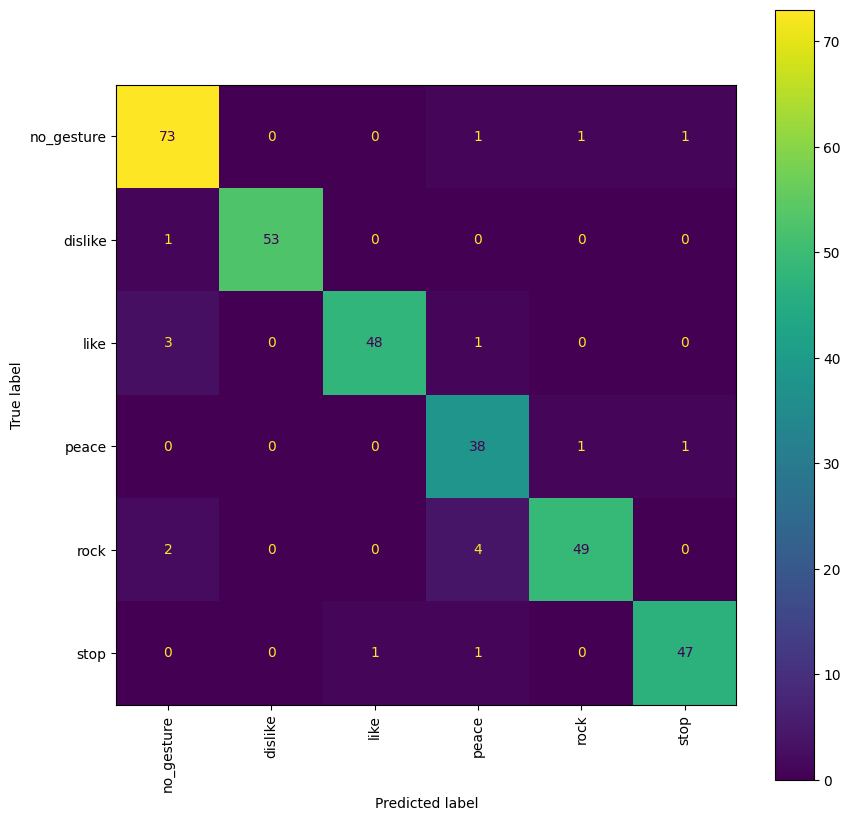

In [ ]:
# let the model make predictions for our training data
y_predictions = model.predict(X_test)

# we get a 2D numpy array with probabilities for each category
#print('before', y_predictions)

# to build a confusion matrix, we have to convert it to classifications
# this can be done by using the argmax() function to set the probability to 1 and the rest to 0
y_predictions = np.argmax(y_predictions, axis=1)

#print('probabilities', y_predictions)

# create and plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_predictions)

fig = plt.figure(figsize=(10, 10))

ConfusionMatrixDisplay(conf_matrix, display_labels=label_names).plot(ax=plt.gca())

plt.xticks(rotation=90, ha='center')
pass

# Evaluate images

20250611_140304
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
20250611_140316
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
20250611_140320
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
20250611_140333
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
20250611_140339
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
20250611_140342
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
20250611_140354
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
20250611_140357
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
20250611_140404
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
20250611_140416
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
20250611_140420
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
20250611_140424
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
20250611_140433
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
20250611_140438
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
20250611_140444
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
['like', 'like', 'like', 'dislike', 'dislike', 'dislike', 'stop', 'stop', 'stop', 'rock', 'rock', 'rock', 'peace', 'peace', 'peace']
['like', 'stop', 'like', 'dislike', 'dislike', 'dislike',

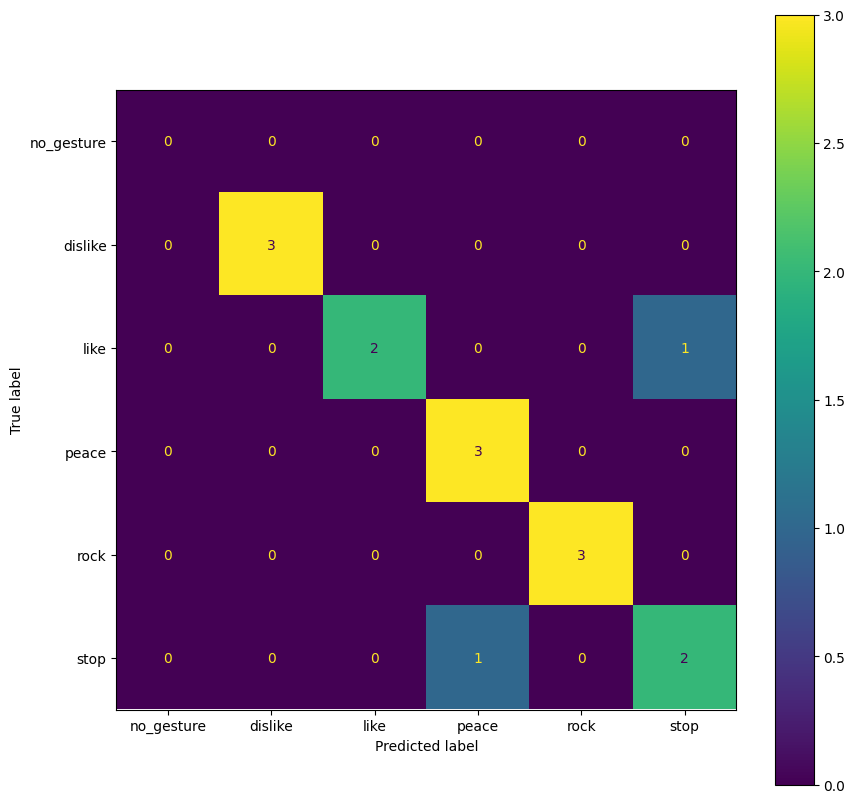

In [ ]:
image_annotations = []
answers = []
true_gestures = []
ANNOTATION_FILE = "annot-richard.json"
IMAGES_PATH = "images"

annotation_file = glob.glob(ANNOTATION_FILE)
with open(annotation_file[0], "r") as f:
    image_annotations: Dict[str, Dict] = json.load(f)

for filename, annotation in image_annotations.items():
    image = cv2.imread(f'{IMAGES_PATH}/{filename}.jpg')
    correct_annotation = image_annotations[filename]

    bbox = correct_annotation['bboxes'][0]

    x1 = int(bbox[0] * image.shape[1])
    y1 = int(bbox[1] * image.shape[0])
    w = int(bbox[2] * image.shape[1])
    h = int(bbox[3] * image.shape[0])
    x2 = x1 + w
    y2 = y1 + h

    crop = image[y1:y2, x1:x2]
    print(filename)
    preprocessed = preprocess_image(crop)
    preprocessed = np.expand_dims(preprocessed, axis=0)

    prediction = model.predict(preprocessed)

    #print(prediction[0])
    answers.append(label_names[np.argmax(prediction[0])])
    true_gestures.append(correct_annotation['labels'][0])

#print(true_gestures)
#print(answers)
conf_matrix = confusion_matrix(true_gestures, answers, labels=label_names)
fig = plt.figure(figsize=(10, 10))
ConfusionMatrixDisplay(conf_matrix, display_labels=label_names).plot(ax=plt.gca())
plt.savefig("conf-matrix.png")
plt.show()